### Unsupervised learning: Jet algorithms

In this notebook you will explore how jets -- sprays of particles emerging from high energy particle collisions -- can be found using algorithms. You should refer to the lecture for background information. If you want to read more, here is a classic review paper from before the LHC started, purely included if you are extra interested: https://arxiv.org/pdf/0906.1833

You are given simulated collision events (simulated using the Pythia Monte Carlo event generator, see www.pythia.org), and your task is to use two examples of clustering algorithms (which are again examples of unsupervised learning) to cluster the particles in these collision events into jets. In the lecture, we went through the k-means algorithm. An implementation, closely following the Wikipedia pseudocode: https://en.wikipedia.org/wiki/K-means_clustering is provided. You should explore this implementation a bit, implement another clustering scheme and compare the two. The tasks are:

1. Run the implemented k-means on a few of the provided events in pythia.dat (100 events). Inspect the output and play with the parameters of the algorithm (change k, enable/disable pT weighting). Look at the plots and explain how they change.
2. A single histogram is already implemented. It displays the (vector) sum of transverse momenta of the leading jet (i.e. the one with the largest pT) in an event. Add another histogram which shows the fraction of pT taken by the leading jet out of all particles in the whole event.
3. (This is the big one!) Implement the anti-kT clustering algorithm (https://arxiv.org/abs/0802.1189). Use the given template for implementation, where some of the boilerplate code has already been put in. Repeat the two first items for anti-kT and make a qualitative comparison. See below for hints to implementing anti-kT.
4. Make a histogram that shows the distance in the eta-phi plane between k-means cluster centers and anti-kT jets for the leading and next-to-leading jet. You should now use the large sample pythia-large.dat (100k events). You can also make histograms showing things like the average number of constituents of the leading jet, or other metrics you come up with yourself to differentiate between the two algorithms.

Extra assignment: When you run k-means over the large sample, you will notice that it fails a handful of times per 1000 events. Inspect the code and see where it fails. Could you introduce better fail-safes in any of the cases rather than just skipping the event?

### Hints and pitfalls
1. The particle type is given by its pdg_id. This is an integer referring to the following table: https://pdg.lbl.gov/2020/reviews/rpp2020-rev-monte-carlo-numbering.pdf -- you can use abs(pdg_id) > 100 for hadrons (as already implemented).
2. Don't spend too much time thinking about about the event format, just use the provided classes. The calculations of eta and phi given in there are correct.
3. Remember that phi is an angle. This means that it wraps around on a circle, phi + 2pi = phi etc. In this notebook phi is wrapped between -pi and pi, see for example the phi method in the Particle class. You may need to remember this.
4. In the k-means implementation, we use a fixed random number seed for reproducibility. Don't remove it.
5. If running the large event sample becomes too slow for you, just reduce the number of events by e.g. breaking at 10k or 20k.

### Hints for anti-kT

Anti-kT is a sequential recombination algorithm. Two key differences from k-means:  
1) You don’t choose the number of jets; you give a radius parameter $R$ and the algorithm decides.  
2) The distance has a physics-motivated form.

Distances for particles/pseudojets $i,j$:
$$
\Delta R_{ij}^2=(\eta_i-\eta_j)^2+\Delta\phi_{ij}^2,\qquad
\Delta\phi_{ij}=\mathrm{wrap}(\phi_i-\phi_j)\in[-\pi,\pi)
$$
$$
d_{ij}=\min\!\left(\frac{1}{p_{T,i}^2},\frac{1}{p_{T,j}^2}\right)\frac{\Delta R_{ij}^2}{R^2},
\qquad
d_{iB}=\frac{1}{p_{T,i}^2}.
$$

Algorithm:
1. Start from all particles of interest (e.g. hadrons with $p_T>0.5~\mathrm{GeV}$, $|\eta|<2.5$) as individual *pseudojets* with 4-vectors $(E,\vec{p})$.  
2. Compute all $d_{ij}$ and all $d_{iB}$. A typical choice is $R=0.6$.
3. Find the global minimum among these distances.  
   - If the winner is some $d_{ij}$: merge $i$ and $j$ by summing their 4-vectors to form a new pseudojet; remove $i,j$, insert the merged one.  
   - If the winner is some $d_{iB}$: finalize $i$ as a jet; remove it from the active list.  
4. Recompute all distances (since $p_T,\eta,\phi$ changed) and repeat until no pseudojets remain.  
5. Sort the finalized jets by decreasing $p_T$. 

*Note:* Always wrap $\Delta\phi$ to $[-\pi,\pi)$. This naïve implementation (recomputing everything each step) is fine for notebook-scale events, but will suffer in real applications.

*Note:* The method pop(i) removes the element sitting at index i from a list. This could be very convenient. Note that when you have popped one element from a list, the other indices will change.


### Handing in the assignment
The assignment should be handed in on XXXX, by uploading your completed notebook to YYYY.

In [3]:
# Imports and basic style
import math
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams["axes.grid"] = True

In [4]:
# A simple particle data container class
class Particle:
    def __init__(self, event_id, pdg_id, px, py, pz, e):
        self.event_id = event_id
        self.pdg_id = pdg_id
        self.px = px
        self.py = py
        self.pz = pz
        self.e = e

    # We define the following methods with the "property"
    # keyword. This means that it will behave as a property
    # and not a method
    @property
    def phi(self):
        phi_calc = np.arctan2(self.py, self.px)
        # Wrap to -pi <= phi < pi
        return (phi_calc + np.pi) % (2*np.pi) - np.pi

    @property
    def eta(self):
        pt = self.pT 
        pAbs  = np.hypot(pt, self.pz)
        if pt < 1e-12:
            # pseudorapidity -> p/m infty as pt -> 0
            return np.sign(self.pz) * np.inf
        return np.sign(self.pz) * np.log((pAbs + abs(self.pz)) / pt)
    
    @property
    def pT(self):
        return np.sqrt(self.px**2 + self.py**2)

# A simple event class to implement *filters*
class Event:
    def __init__(self, eid, particles = None):
        self.event_id = eid
        self.particles = [] if particles is None else particles

    def add(self, p: Particle):
        assert p.event_id == self.event_id
        self.particles.append(p)

    # Make it behave like a container of Particles
    def __iter__(self):
        return iter(self.particles)

    def __len__(self):
        return len(self.particles)

    # Filters: keep only particles fulfilling some condition. Feel free to experiment with
    # other filters. For example: Keep only a selected subset of hadrons (with long decay times),
    # keep only particles within a restricted interval in eta.
    # Keep only hadrons.
    def hadrons(self):
        return Event(self.event_id, [p for p in self.particles if abs(p.pdg_id) >= 100])

    # Keep only particles with more than a given pT.
    def with_pt_min(self, pt_min):
        return Event(self.event_id, [p for p in self.particles if p.pT >= pt_min])

# Simple file reader. Give the path and return a list of events.
def load_events_txt(path):
    events = {}
    with open(path) as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            toks = line.split()
            if len(toks) != 6:
                raise ValueError(f"Bad line (expected 6 tokens): {line}")
            eid_s, pdg_s, px_s, py_s, pz_s, e_s = toks
            eid  = int(eid_s)
            pdg  = int(pdg_s)
            px   = float(px_s)
            py   = float(py_s)
            pz   = float(pz_s)
            e   = float(e_s)
            
            if eid not in events:
                events[eid] = Event(eid)
            events[eid].add(Particle(eid, pdg, px, py, pz, e))

    return [events[k] for k in sorted(events)]



In [5]:
# Helper functions for plotting
# Plot a single event
def plot_event(ev, title=None):
    if len(ev) == 0:
        print(f"(Event {ev.event_id}) empty after filters")
        return
    pt, eta, phi = [], [], []
    for p in ev:
        pt.append(p.pT)
        eta.append(p.eta)
        phi.append(p.phi)
    sizes = 10.0 + 3.0* np.sqrt(pt)

    sc = plt.scatter(phi, eta, s=sizes, c=pt, cmap="viridis", alpha=0.85, edgecolor="none")
    cb = plt.colorbar(sc)
    cb.set_label(r"$p_T$ [GeV]")

    plt.xlim(-np.pi, np.pi); plt.xlabel(r"$\phi$ [rad]")
    plt.ylim(-2.8, 2.8);     plt.ylabel(r"$\eta$")
    plt.title(title or f"Event {ev.event_id}")
    plt.grid(True, ls="--", alpha=0.3)
    plt.show()

# Plot a single event with clusters marked.
def plot_event_with_clusters(ev, clusters, title=None):
    # color map
    colors = plt.cm.tab10.colors
    for j, c in enumerate(clusters):
        phis = [p.phi for p in c]
        etas = [p.eta for p in c]
        pts  = [p.pT  for p in c]
        sizes = 10.0 + 3.0*np.sqrt(pts)
        plt.scatter(phis, etas, s=sizes, color=colors[j % 10], alpha=0.85,
                    edgecolor="none", label=f"cluster {j} (n={len(c)})")
        # centers
        plt.scatter([c.phi], [c.eta], marker="x", s=120, c="k", linewidths=2)

    plt.xlim(-np.pi, np.pi); plt.ylim(-2.8, 2.8)
    plt.xlabel(r"$\phi$ [rad]"); plt.ylabel(r"$\eta$")
    plt.title(title or f"Event {ev.event_id} — with k-means clusters")
    plt.grid(True, ls="--", alpha=0.3)
    plt.legend()
    plt.show()


In [6]:
# Holds particles clustered with k-means
class Cluster:
    def __init__(self, phi, eta):
        self.phi = phi
        self.eta = eta
        self.particles = []
    # Make it behave like a container of Particles
    def __iter__(self):
        return iter(self.particles)

    def __len__(self):
        return len(self.particles)

    # Aggregate quantities
    # Transverse momentum of combined particles in the cluster
    def clusterpT(self):
        px = py = 0.
        for p in self.particles:
            px += p.px
            py += p.py
        return np.sqrt(px*px + py*py)

# Distance between two particles, cluster/particle or cluster/cluster
# in the phi-eta plane.
def dist(p1, p2):
    dphi = (p1.phi - p2.phi + np.pi) % (2*np.pi) - np.pi
    return np.sqrt(dphi**2 + (p1.eta - p2.eta)**2)

# Implementation of the k-means algorithm
import random as rnd
def kmeans(k, event, ptw = False, tol=1e-4):
    # Sanity check of input
    if len(event.particles) < k:
        print(f"Event {event.event_id} had fewer than k={k} particles. Skipping")
        return []
    # Empty list of clusters
    clusters = []
    # Pick k random particles from event 
    # to use as seed for clusters
    index = []
    rnd.seed(1234)
    while len(index) < k:
        i = int(rnd.random() * len(event.particles))
        if i not in index:
            index.append(i)
            
    # Put the seeds in a list.
    clusters = [Cluster(event.particles[i].phi, event.particles[i].eta) for i in index]
    # Set up loop until convergence
    converged = False
    # Or until we run out of tries
    nTries = 0
    while not converged:
        # Assign each particle in the event to the nearest cluster
        for p in event.particles:
            closest_index = 0
            closest_dist = dist(p, clusters[0])
            for i,c in enumerate(clusters[1:]):
                d = dist(p,c)
                if d < closest_dist:
                    closest_dist = d
                    closest_index = i+1
            clusters[closest_index].particles.append(p)
        # Make new clusters as the center of old clusters
        new_clusters = []
        # calculate distance between new and old clusters for convergence
        sum_dist = 0.
        for c in clusters:
            # Optionally weight particles by their pT
            weights = [p.pT if ptw else 1. for p in c]
            sumW = sum(weights)
            if sumW == 0:
                print("Cluster center has been isolated. Skipping event")
                return []
            # Mean eta
            eta_mean = sum([p.eta * w for p,w in zip(c,weights)]) / sumW
            # Use circular mean for angles
            sin_mean = sum([np.sin(p.phi) * w for p,w in zip(c,weights)]) / sumW
            cos_mean = sum([np.cos(p.phi) * w for p,w in zip(c,weights)]) / sumW
            phi_mean = np.arctan2(sin_mean, cos_mean)
            c2 = Cluster(phi_mean, eta_mean)
            sum_dist += dist(c, c2)
            new_clusters.append(c2)
        if sum_dist < tol:
            converged = True
        else:
            clusters = new_clusters
            nTries+=1
        if nTries > 20:
            print('Tried 20 times without converging!')
            return []

    return clusters
        


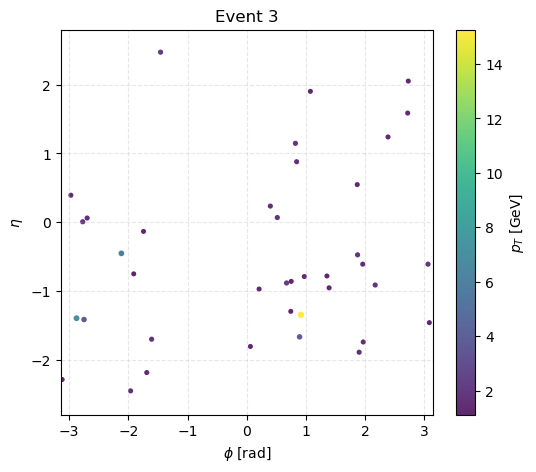

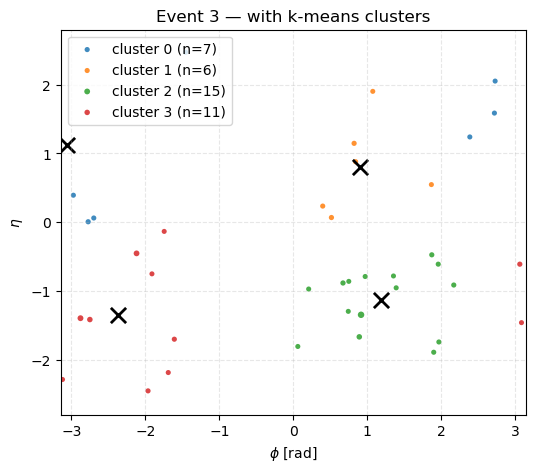

0 events processed


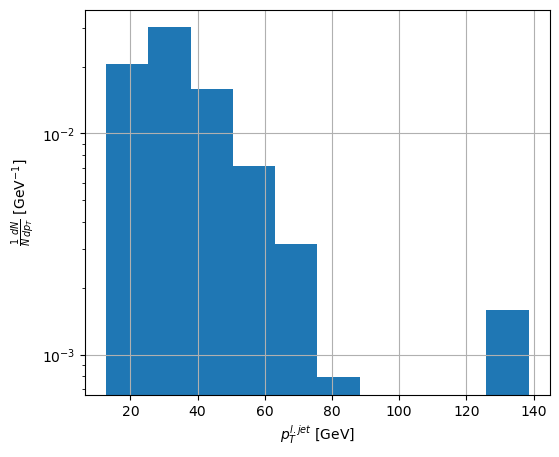

In [7]:
# Load a small sample of events
#events = load_events_txt('pythia-large.dat')
events = load_events_txt('pythia.dat')

# Cluster a single event and plot it
event = events[3].hadrons().with_pt_min(1)
clusters = kmeans(4, event)
plot_event(event)
plot_event_with_clusters(event, clusters)
# Loop over all events and find the leading jet
# Put its pT in a histogram
pts = []
for i,e in enumerate(events):
    if i%1000 == 0:
        print(str(i)+' events processed')
    clusters = kmeans(4, e)
    pTmax = 0
    for c in clusters:
        clpt = c.clusterpT()
        if clpt > pTmax:
            pTmax = clpt
    pts.append(pTmax)

# Plot as a histogram.
plt.hist(pts, density=True, log=True)
plt.xlabel(r'$p^{l. jet}_T$ [GeV]')
plt.ylabel(r'$\frac{1}{N}\frac{dN}{dp_T}$ [GeV$^{-1}$]')

plt.show()

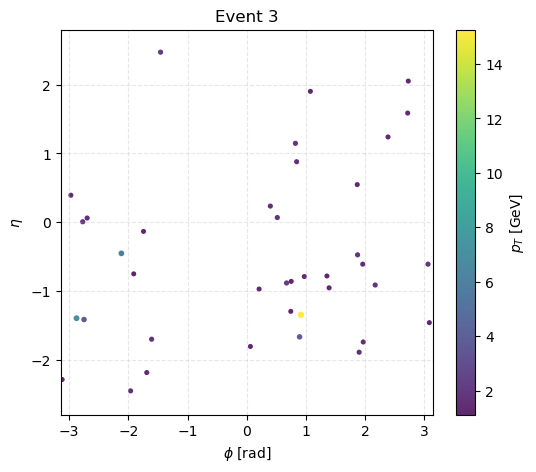

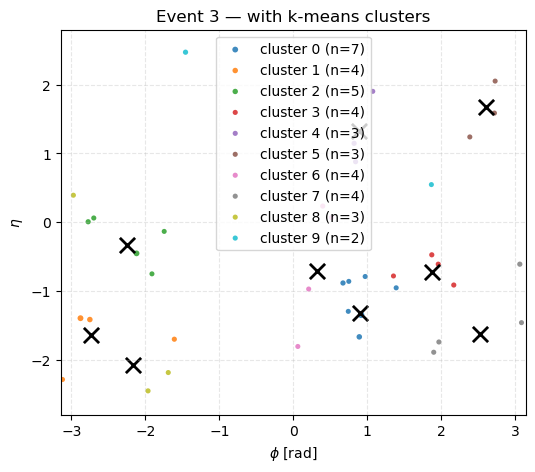

In [17]:
# In this block you should complete the implementation of anti-kT. A template is provided where you should complete the TODOs.
# You are of course also free to reimplement from scratch, but I suspect the template could be very helpful!

# Define a Pseudo-jet class which inherits from the Particle class.
# This means that we don't need to re-implement the kinematics calculations.
class Pseudojet(Particle):
    # We initialize it with a particle
    def __init__(self, p: Particle):
        self.px = p.px
        self.py = p.py
        self.pz = p.pz
        self.e = p.e
        # We always want to know which particles/pseudojets we have
        # combined into this pseudojet.
        self.particles = [p]
    # Make it behave like a container of Particles
    def __iter__(self):
        return iter(self.particles)

    def __len__(self):
        return len(self.particles)

# Combine two pseudojets into a single pseudojet
def combine(p1: Pseudojet, p2: Pseudojet):
    pj = Pseudojet(Particle(0, 0, 0, 0, 0, 0))
    pj.px = p1.px + p2.px
    pj.py = p1.py + p2.py
    pj.pz = p1.pz + p2.pz
    pj.e = p1.e + p2.e
    pj.particles = p1.particles + p2.particles
    return pj

# Compute the anti-kt distance between two pseudojets.
def akt_dist(p1: Pseudojet, p2: Pseudojet, R):
    deltaR2 = (p1.eta - p2.eta)**2 + (p1.phi - p2.phi)**2
    dij = (deltaR2/R**2) * (min(p1.pT**(-2), p2.pT**(-2)))
    return dij

def remove_two_elements(l,i,j):
    if i > j:
        l.pop(i)
        l.pop(j)
    else:
        l.pop(j)
        l.pop(i)

def antikT(event, R):
    # Step 1: Make a list of all particles as pseudo-jets
    pseudojets = [Pseudojet(p) for p in event]
    # Make an empty list of jets that we want to fill in
    # the loop below.
    jets = []
    # Continue until there are no more pseudojets left
    while pseudojets:
        # Step 2. Compute all distances, find minimum.
        # TODO: Do a double-loop (or upper-triangular)
        # over all pseudo-jets to find the pair i,j with
        # the shortest distance, as well as the shortest
        # diB.
        diB = 0
        dijmin=[np.inf, [np.inf, np.inf]]
        for i in range(len(pseudojets)):
            for j in range(len(pseudojets)):
                if i == j:
                    continue
                if akt_dist(pseudojets[i],pseudojets[j],R) < dijmin[0]:
                    dijmin[0] = akt_dist(pseudojets[i],pseudojets[j],R)
                    dijmin[1] = [i, j]
                    diB = pseudojets[i].pT**(-2)
                else:
                    continue
        
        combined_pseudojet = combine(pseudojets[dijmin[1][0]], pseudojets[dijmin[1][1]])
        if diB <= dijmin[0]:
            jets.append(combined_pseudojet)
            remove_two_elements(pseudojets, dijmin[1][0], dijmin[1][1])
        else:
            pseudojets[dijmin[1][0]] = combined_pseudojet
            pseudojets.pop(dijmin[1][1])
            
        # Step 3: Determine the winner.
        # TODO: If diB <= dij mark it as a jet and remove it from
        # the pseudojet list
        # Else, remove the two pseudojets and add the combination.
        
    
    return jets

# Here you can then play with the implementation.
event = events[3].hadrons().with_pt_min(1)
jets = antikT(event, 0.6)
plot_event(event)
plot_event_with_clusters(event, jets)